# Modeling with Sentiment and Financials Data
First we will set up our tools and libraries and install any packages we do not have for our modeling.

In [1]:
#!pip xgboost -q

In [2]:
#!pip install imbalanced-learn

In [3]:
# Base
import numpy as np # Lin Algebra
import pandas as pd # Data processing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rc('figure',figsize=(16,12))

# Sentiment Analysis
import os
import re
import string
import nltk
import requests
import statsmodels.api as sm

# Natural Language Modeling
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from nltk import word_tokenize
import spacy as sp
nlps = sp.load('en_core_web_sm')
import random

# Standard Modeling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR, AutoReg
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

import warnings
# Ignore that annoying Deprecation Warning
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kaicansler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Load our wallstreetbets sentiment data for cleaning and sentiment analysis.

In [4]:
wsb_data = pd.read_csv('data/reddit_wsb.csv')
wsb_data = wsb_data[pd.to_datetime(wsb_data.timestamp).dt.year>=2021]
wsb_data

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56
...,...,...,...,...,...,...,...,...
50065,Block Trader takes massive position in WISH,194,o0pxeb,https://www.msn.com/en-us/money/news/block-tra...,23,1.623824e+09,NaN,2021-06-16 09:09:33
50066,Up more than 4x on $AMC calls and still holdin...,37,o0pt50,https://i.redd.it/2g1ek07d5i571.png,4,1.623823e+09,NaN,2021-06-16 09:03:54
50067,Yolo on $WISH for 23k shares from 8.69 and ave...,501,o0priy,https://i.redd.it/rk2la0n85i571.jpg,47,1.623823e+09,NaN,2021-06-16 09:01:49
50068,RICK- Strip clubs- Retarded DD,15,o0poqj,https://www.reddit.com/r/wallstreetbets/commen...,23,1.623823e+09,Upsides-PT 86 dollars to UrAnus\n\nSo you apes...,2021-06-16 08:58:15


WallStreetBets contains many words that show sentiment toward a stock being positive or negative which is not understood by our vader lexicon. We will update our lexicon with new words and their subsequent scores to improve our sentiment analysis.

Words such as 'tendies', 'moon', and even simple words such as 'buy' are understood to be a bullish sentiment on the stock that the vader lexicon will not recognize.

In [5]:
# Adding wsb/reddit flavor to vader to improve sentiment analysis, score: 4.0 to -4.0
new_words = {
    'citron': -4.0,  
    'hidenburg': -4.0,        
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
    'break': 2.0,
    'tendie': 2.0,
    'tendies': 2.0,
    'town': 2.0,     
    'overvalued': -3.0,
    'undervalued': 3.0,
    'buy': 4.0,
    'sell': -4.0,
    'gone': -1.0,
    'gtfo': -1.7,
    'paper': -1.7,
    'bullish': 3.5,
    'bearish': -3.5,
    'bagholder': -1.7,
    'stonk': 1.9,
    'green': 1.9,
    'money': 1.2,
    'print': 2.2,
    'rocket': 2.2,
    'bull': 2.9,
    'bear': -2.9,
    'pumping': -1.0,
    'sus': -3.0,
    'offering': -2.3,
    'rip': -4.0,
    'downgrade': -3.0,
    'upgrade': 3.0,     
    'maintain': 1.0,          
    'pump': 1.9,
    'hot': 1.5,
    'drop': -2.5,
    'rebound': 1.5,  
    'crack': 2.5,
}

# Stock Movement Prediction with Stock Sentiment
Now we want to identify stocks with most sentiment scores and use those scores to drive predictions.
We will:
1. Identify top 5 stocks.
2. Use top 5 stocks to create new dataframe with sentiment and stock data.
3. Use AlphaVantage to get timeseries price data.
4. Prediction Modeling.

## Find Target Stocks
Obtain Stock Ticker list from nasdaq to identify ticker mentions in WSB posts. We pulled the ticker list from nasdaq:
https://www.nasdaq.com/market-activity/stocks/screener?exchange=nasdaq&letter=0&render=download 

In [6]:
stocks = pd.read_csv('./data/tickers.csv')

# Convert Last Sale to a Float type.
stocks['Last Sale'] = stocks['Last Sale'].str.replace('$', '')
stocks['Last Sale'] = pd.to_numeric(stocks['Last Sale'], downcast='float')
type(stocks['Last Sale'][0])

# Filter out stocks >$3 and > $100 million cap
price_filter = stocks['Last Sale'] >= 3.00
cap_filter = stocks['Market Cap'] >= 100000000

# make set of symbols
stocks = set(stocks[(price_filter) & (cap_filter)]['Symbol'])

blacklist = {
    'I', 'WSB', 'THE', 'A', 'YOLO', 'TOS', 'CEO', 'DD', 'IT', 'OPEN', 'ATH', 'PM', 'IRS', 'FOR', 'BE', 'IMO', 'ALL', 'RH',
    'EV', 'TOS', 'CFO', 'CTO', 'OK', 'KYS', 'FD', 'US', 'USA', 'IT', 'RIP', 'ATM', 'ITM', 'IMO', 'LOL', 'AM', 'BE', 'PRAY',
    'FOMO', 'EDIT', 'IPO', 'BUT','USD', 'ON', 'GO', 'MOVE', 'CAN', 'NEXT', 'ME', 'REAL', 'LIFE', 'PLAY', 'EVER', 'STEP', 'ECHO',
    'RIDE', 'RARE', 'GOOD', 'ROAD', 'HAS', 'COOL', 'LOVE', 'ACT', 'ANY', 'HOPE', 'FORM', 'FUND', 'FREE', 'VERY', 'GAIN', 'CASH',
    'HEAR', 'CARE', 'EYE', 'FIVE', 'TEAM', 'LAND', 'TRUE', 'TELL', 'RUN', 'FAT', 'JOBS', 'TECH', 'TALK', 'MF', 'KIDS', 'FATE', 'PLUS',
    'POOL', 'ROCK', 'LOOP', 'YELL', 'BAND', 'TRIP', 'HOOK', 'UNIT', 'VIEW', 'GLAD', 'CENT', 'LAZY', 'EH', 'TOWN', 'RAIN', 'CAR', 'PLUG',
    'WISH', 'FAST', 'JACK', 'HOOD', 'COIN', 'LAWS', 'ERIC', 'CALM', 'TACO', 'PUCK', 'BRAG', 'SWAG', 'WRAP', 'JAN', 'FEB', 'MAR', 'APR',
    'MAY', 'JUN', 'SEPT', 'OCT', 'NOV', 'DEC', 'NICE', 'COST', 'ROLL', 'FOLD', 'APP', 'MASS', 'FOX', 'API', 'RELY', 'APPS', 'SIRI', 'SLAM',
    'ROOT'
}

### Load Sentiment Data for Modeling

In [7]:
wsb_data.shape

(50069, 8)

In [8]:
# Load title body and timestamp to separate dataframe
sentiment_data = wsb_data[['title', 'body', 'timestamp']].copy()

# Create function to combine title and body
def combine_columns(row):
    return str(row['title']) + ' ' + str(row['body'])
# Combine Title and Body
sentiment_data['text'] = sentiment_data.apply(combine_columns, axis=1)

# Make the string all lower for processing
sentiment_data.text = sentiment_data.text.str.lower()

# Make date without time
sentiment_data.timestamp = pd.to_datetime(sentiment_data.timestamp).dt.date

# Remove Handle info
sentiment_data.text = sentiment_data.text.apply(lambda x: re.sub('@[^\s]+', '', x))

# Remove URLS
sentiment_data.text = sentiment_data.text.apply(lambda x: re.sub(r'http\S+', '', x))

# Remove special characters after handle info
sentiment_data.text = sentiment_data.text.apply(lambda x: ' '.join(re.findall(r'\w+', x)))

# Remove all single characters
sentiment_data.text = sentiment_data.text.apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x))

# Fix double spaces in data
sentiment_data.text = sentiment_data.text.apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))

In [9]:
sentiment_df = pd.DataFrame(sentiment_data)
sentiment_df.drop(columns=['title', 'body'], axis=1, inplace=True)

picks = 5  # Define # of picks we want
posts, count, tickers, a_text = 0, 0, {}, {}

for _, row in sentiment_df.iterrows():
    split = row.text.split(' ') #body_data['body'].apply(lambda x: x.split(' '))
    row['text_split'] = split
    for word in split:
        word = word.replace("$", "")
        word = word.upper()
        # upper = ticker, length of ticker <= 5, excluded words
        if len(word) <= 5 and word not in blacklist and word in stocks:
                                    
            # counting tickers
            if word in tickers:
                tickers[word] += 1
                a_text[word].append(row.text)
                count += 1
            else:
                tickers[word] = 1
                a_text[word] = [row.text]
                count += 1

In [10]:
# Sorts the dictionary
# Symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))
symbols = {k: v for k, v in sorted(tickers.items(), key=lambda item: item[1], reverse = True)}
top_picks = list(symbols.keys())[0:picks]

print(f"\n{picks} most mentioned picks: ")
times = []
top = []
for i in top_picks:
    print(f"{i}: {symbols[i]}")
    times.append(symbols[i])
    top.append(f"{i}: {symbols[i]}")


5 most mentioned picks: 
TSLA: 970
AMZN: 810
AMD: 784
VIA: 567
CLOV: 510


*Top 5* most mentioned stocks are Tesla, Amazon, AMD, Viacom, and Clover. They have alot of mentions and will be useful to have more sentiment scores to go off of for our prediction modeling. We will use these 5 for our Classification models.

In [11]:
# Create scores and s empty dictionary to collect scores
scores, s = {}, {}

# Instantiate sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Adding our custom words and their scores to the lexicon
vader.lexicon.update(new_words)

# Analyze and add sentiment scores for all text data of each post
picks_sentiment = list(symbols.keys())[0: picks]
for symbol in picks_sentiment:
    stock_bodies = a_text[symbol]
    for text in stock_bodies:
        score = vader.polarity_scores(text)
        if symbol in s:
            s[symbol][text] = score
        else:
            s[symbol] = {text: score}
        if symbol in scores:
            for key, _ in score.items():
                scores[symbol][key] += score[key]
        else:
            scores[symbol] = score

    # Calculating averages of the scores for each stock
    for key in score:
        scores[symbol][key] = scores[symbol][key] / symbols[symbol]
        scores[symbol][key] = "{pol:.3f}".format(pol=scores[symbol][key])


In [12]:
# Printing sentiment analysis of each stock
print(f"\nSentiment analysis of top {picks} picks:")
df = pd.DataFrame(scores)
df.index = ['Negative', 'Neutral', 'Positive', 'Total_Compound']
df = df.T
print(df)



Sentiment analysis of top 5 picks:
     Negative Neutral Positive Total_Compound
TSLA    0.090   0.754    0.157          0.591
AMZN    0.021   0.939    0.040         -0.234
AMD     0.067   0.766    0.167          0.829
VIA     0.084   0.776    0.140          0.563
CLOV    0.079   0.745    0.176          0.621


In [13]:
# Define the listing list with the stocks you want to extract
listing  = list(df.index)

# Define the function which takes a string and a list of words to extract as inputs
def listing_splitter(text, listing):
    # Try except to handle np.nans in input
    try:
        # Extract the list of flags
        flags = [l for l in listing if l in text.upper()]
        # If any flags were extracted then return the list
        if flags:
            return flags
        # Otherwise return np.nan
        else:
            return np.nan
    except AttributeError:
        return np.nan

# Apply the function to the column to understand what stock the sentiment is referring to
sentiment_df['stock'] = sentiment_df['text'].apply(lambda x: listing_splitter(x, listing))

In [14]:
# Turn off warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Drop NA values and then explode list of stock mentions for final preprocessing
target_df = sentiment_df.dropna()
target_df = target_df.explode('stock')
target_df.reset_index(inplace=True)
target_df.drop('index', axis=1, inplace=True)

In [15]:
# Instantiate Sentiment Intensity Analyzer
vader = SentimentIntensityAnalyzer()
# Adding custom words to Vader Lexicon
vader.lexicon.update(new_words)

# Load sentiments and splitting sentiments array into its respective columns
target_df['sentiments'] = target_df['text'].apply(lambda x: vader.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
target_df['Positive Sentiment'] = target_df['sentiments'].apply(lambda x: x['pos']) 
target_df['Neutral Sentiment'] = target_df['sentiments'].apply(lambda x: x['neu'])
target_df['Negative Sentiment'] = target_df['sentiments'].apply(lambda x: x['neg'])
target_df['Total Compound'] = target_df['sentiments'].apply(lambda x: x['compound'])

# Drop sentiments array
target_df.drop(columns=['sentiments'],inplace=True)

In [16]:
target_df

,timestamp,text,stock,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Total Compound
0,2021-01-28,warning dd s3 partner short interest are not a...,TSLA,0.121,0.725,0.154,-0.5984
1,2021-01-28,fellow wsbers don sleep on demo day accumulate...,VIA,0.160,0.743,0.097,0.9000
2,2021-01-28,the anatomy of blatant market manipulation to ...,VIA,0.096,0.763,0.141,-0.9979
3,2021-01-28,the real dd on slv the worlds biggest short sq...,VIA,0.150,0.771,0.079,0.9993
4,2021-01-28,call your brokerage and demand compensation fo...,VIA,0.126,0.725,0.150,-0.5324
...,...,...,...,...,...,...,...
2037,2021-06-16,bark 1 2 mm position dog brand ready to takeov...,VIA,0.136,0.825,0.039,0.9988
2038,2021-06-16,now that shit has somewhat calmed down here le...,VIA,0.130,0.765,0.105,0.9755
2039,2021-06-16,amd yolo update nan,AMD,0.412,0.588,0.000,0.2732
2040,2021-06-16,yolo ing into tenditown on the clov train curr...,CLOV,0.116,0.884,0.000,0.2732


# Combine Financial Data for Modeling
We are using AlphaVantage API Time Series Daily dataset to pull the open, high, low, close, and volume for each stock. We will use this information to feature engineer direction and log return for our model.

Direction will be our target variable and be the feature that our model will predict. 

1. Take our target data and understand the date range of our comments.

In [17]:
# Date range of our dataset
combined_data = target_df.copy()
combined_data.rename(columns={'timestamp':'Date'}, inplace=True)
print(combined_data['Date'].min())
print(combined_data['Date'].max())
print(combined_data['Date'].max() - combined_data['Date'].min())

2021-01-28
2021-06-22
145 days, 0:00:00


Set up our functions for the API call, creating dataframe, adding the stock name to each row and complete our feature engineering to make an iterative process.

In [18]:
from datetime import datetime

# Get API call for target stock from AlphaVantage
def get_daily_adjusted_price_data(api_key, stock):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&outputsize=full&apikey={api_key}"
    raw = requests.get(url).json()

    return raw

# Convert JSON data to DataFrame for preprocessing and modeling
def create_dataframe(raw):
    dataframe = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

    for key in raw["Time Series (Daily)"].keys():
        dataframe = pd.concat([dataframe,
            pd.Series(
                [
                    datetime.strptime(key, '%Y-%m-%d').date(),
                    pd.to_numeric(raw["Time Series (Daily)"][key]['1. open']),
                    pd.to_numeric(raw["Time Series (Daily)"][key]["2. high"]),
                    pd.to_numeric(raw["Time Series (Daily)"][key]["3. low"]),
                    pd.to_numeric(raw["Time Series (Daily)"][key]["4. close"]),
                    pd.to_numeric(raw["Time Series (Daily)"][key]["5. volume"])           
                ], index=dataframe.columns
            ).to_frame().T
            ], ignore_index=True
        )
        
    return dataframe

# Add stock name to column for each row
def add_column(dataframe, value_to_add, column_name):
    dataframe[f"{column_name}"] = [value_to_add for x in range(len(dataframe))]

    return dataframe

# Calculates the log return of stock from closing of that day to the close of chosen n days
def calc_returns(dataframe, n_days):
    dataframe[f"{n_days}d-logreturn"] = np.log(dataframe['Close'].astype(float) / dataframe['Close'].astype(float).shift(periods=-n_days))

    return dataframe

# Calculate the direction of movement from closing on the day and closing of the next day
def calc_direction(dataframe, n_days):
    dataframe[f"{n_days}d-direction"] = [1 if x > 0 else 2 if x < 0 else 0 for x in dataframe[f"{n_days}d-logreturn"]]
    return dataframe

# Concatenates our dataframe and organizing our price dataframe
def concat_dataframes(dataframe1, dataframe2):
    price_data = pd.concat([dataframe1, dataframe2], ignore_index=True)
    price_data = price_data[['Date',
                             'stock',
                             'Open',
                             'High',
                             'Close',
                             'Volume',
                             '1d-logreturn',
                             '1d-direction',
                             '10d-logreturn',
                             '30d-logreturn',
                             '90d-logreturn'
                             ]]

    return price_data

def clean_dataframe(dataframe):
    # First n values in direction columns should be NaN
    dataframe['1d-direction'][0] = np.nan

    # Shift columnd to properly align in a manner to ensure the features are observable
    # with respect to the target
    dataframe['1d-logreturn'] = dataframe['1d-logreturn'].shift(1)
    dataframe['1d-direction'] = dataframe['1d-direction'].shift(1)
    dataframe['10d-logreturn'] = dataframe['10d-logreturn'].shift(1)
    dataframe['30d-logreturn'] = dataframe['30d-logreturn'].shift(1)
    dataframe['90d-logreturn'] = dataframe['90d-logreturn'].shift(1)

    dataframe.dropna(inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.drop('index', axis=1, inplace=True)

    return dataframe

2. Collect and Create our Prices DataFrame

In [19]:
# Create Price DataFrame
price_data = pd.DataFrame()
bad_api_calls = []
api_key = os.environ.get("API_KEY")

# Iterate through stocks of interest, call the API, feature engineer, and combine to our end dataframe.
for stock in listing:
    try:

        # Make api call
        api_call = get_daily_adjusted_price_data(api_key, stock)

        # Create dataframe
        df_temp = create_dataframe(api_call)
        
        # Add column for stock symbol
        add_column(df_temp, stock, 'stock')

        # Calc returns
        calc_returns(df_temp, 1)
        calc_returns(df_temp, 10)
        calc_returns(df_temp, 30)
        calc_returns(df_temp, 90)

        # Calc direction
        calc_direction(df_temp, 1)

        # Concat dataframes
        price_data = concat_dataframes(price_data, df_temp)

    except KeyError:
        bad_api_calls.append(stock)
        pass

# Check for bad API calls which can lead to missing data
print(bad_api_calls)

[]


In [20]:
# Clean dataset with our clean function
final_price_data = clean_dataframe(price_data)

Removed day-direction as we do not have information on what time the posts were made for our sentiment analysis. Our prediction will contain bias as the sentiment could be positive because of the movement for the day making it useless for future data and predictions.

In [21]:
# Feature engineer our classifcation variable
# final_price_data["day-direction"] = [1 if x > 0 else 2 if x < 0 else 0 for x in (np.log(final_price_data['Close'].astype(float) / final_price_data['Open'].astype(float)))]

In [22]:
# Filter out date range to focus on the particular dates in which the sentiment analysis was conducted
filter_ = (final_price_data['Date'] >= combined_data['Date'].min()) & (final_price_data['Date'] <= combined_data['Date'].max())

final_price_data = final_price_data[filter_]
final_price_data.reset_index(inplace=True)
final_price_data.drop('index', axis=1, inplace=True)

***Important:*** For our modeling we want to aim for a prediction accuracy higher than the distribution of our target variable classifiers. Looking at the distribution of '1d-direction' we can see that Increases and Decreases are evenly distributed. and we should aim for a prediction accuracy score higher than 50.3%.

In [23]:
# Distribution of our direction our target variable
final_price_data['1d-direction'].value_counts(normalize=True)

1d-direction
2.0    0.502970
1.0    0.491089
0.0    0.005941
Name: proportion, dtype: float64

In [24]:
# In this step, we will combine the price dataset and a sentiment analysis dataset into one
# 'combined_df'
final_data = combined_data.merge(final_price_data, on=['Date', 'stock'], how='left', suffixes=(None, "_y"))
final_data.drop(['text'], axis=1, inplace=True)
final_data = final_data.groupby(by=['Date', 'stock']).mean()
final_data.reset_index(inplace=True)

In [25]:
print('Before Removing Missing: ', len(final_data))
# Remove missing values and reset index
final_data.dropna(inplace=True)
final_data.reset_index(drop=True, inplace=True)

print('After Removing Missing: ', len(final_data))

Before Removing Missing:  476
After Removing Missing:  333


In [26]:
def float_column(column):
    final_data[column] = final_data[column].astype(float)

In [27]:
# Clean our data. 1d-direction is derived from 1d-logreturn so we need to remove it to avoid data leakage.
final_data.drop(['Date', 'Open', 'Close', '1d-logreturn', '10d-logreturn'], axis=1, inplace=True)
# Stock price with no movement is a special case and should be removed. reasons include pre-IPO
final_data.drop(final_data[final_data['1d-direction'] == 0].index, inplace=True)
final_data.reset_index(drop=True, inplace=True)

# Turn our numerical data to float for classification modeling.
for column in final_data.select_dtypes(exclude=[np.number]).columns:
    if column == 'stock':
        pass
    else:
        float_column(column)

# Turn 1d-direction to direction for easy use and lower all our feature names.
final_data.rename({'1d-direction': 'direction'}, axis=1,inplace=True)
final_data.columns = final_data.columns.map(lambda row: "_".join(row.lower().split(" ")))

In [28]:
# Print a Confidence Matrix
def conf_matrix(y_true, y_pred):
    """
    Plots a standard confusion matrix in seaborn
    """
    cm = confusion_matrix(y_true, y_pred) # Create confusion matrix 
    # Plot confusion matrix
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Bullish', 'Bearish'], yticklabels=['Bullish', 'Bearish'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
# Create function to print results    
def print_results(y_train, y_pred_train, y_test, y_pred_test):
    """
    Prints the Recall, Accuracy, and F1 score of Predictions.
    """
    print('Recall score for testing set: ', round(recall_score(y_train,y_pred_train, average='weighted'),4))
    print('Recall score for validation set: ', round(recall_score(y_test,y_pred_test, average='weighted'),4))
    print('Accuracy score for testing set: ', round(accuracy_score(y_test,y_pred_test),4))
    print('F1 score for testing set: ', round(f1_score(y_test, y_pred_test, average='weighted'),4))

## Modeling
**Process:**
1. Compare multiple classifier models to find the best baseline which contains just our sentiment scores and price data.
2. Compare baseline model to models containg price data and technicals dataset as well as all 3 datasets together.
3. Hyperparameter Tune the best model from the different combination of datasets.

**Baseline model:**
1. The baselinemodel will contain only the sentiment scores and price datasets.
2. Dataset will be MinMaxScaled and OnehotEncoded before fitting the model.
3. We will utilise ROC score to compare and choose our baseline model.

In [29]:
# Load our X and y variables
X = final_data.drop(['direction'], axis=1)
y = final_data['direction']

# One hot encode our stock data and drop first to address data leakage
one_hot = pd.get_dummies(X['stock'], drop_first=True)
X.drop(['stock'], axis=1, inplace=True)
X = pd.concat([X, one_hot], axis=1)
#X.drop(['AMD'], axis=1, inplace=True)

# Train test split and then hold out a validation set for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42) #hold out 25% of the data for testing
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.25, random_state=42) #hold out 25% of the data for validation

# Scale our data for modeling with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [30]:
# Instatiate different models, get scores, to Compare performance
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)

lr = LogisticRegression(max_iter=1000)
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv = 5)

dt = DecisionTreeClassifier()
dt_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)

rf = RandomForestClassifier()
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)

gb = GradientBoostingClassifier(loss='exponential')
gb_scores = cross_val_score(gb, X_train_scaled, y_train, cv=5)

print(f"KNN mean scores: {np.mean(knn_scores):.4}")

print(f"Logistic Regression mean scores: {np.mean(lr_scores):.4}")

print(f"Decision Tree mean scores: {np.mean(dt_scores):.4}")

print(f"Random Forest mean scores: {np.mean(rf_scores):.4}")

print(f"Gradient Boosting mean scores: {np.mean(gb_scores):.4}")

# save best model
best_model = {
    knn: np.mean(knn_scores),
    lr: np.mean(lr_scores),
    rf: np.mean(rf_scores),
    gb: np.mean(gb_scores)
}

# sort by mean scores (dict values) then select the last model (highest mean scores)
best_model_dict = {k: v for k, v in sorted(best_model.items(), key=lambda item: item[1])}
best_model = list(best_model_dict.keys())[-1]

KNN mean scores: 0.5477
Logistic Regression mean scores: 0.5118
Decision Tree mean scores: 0.5118
Random Forest mean scores: 0.5158
Gradient Boosting mean scores: 0.5238


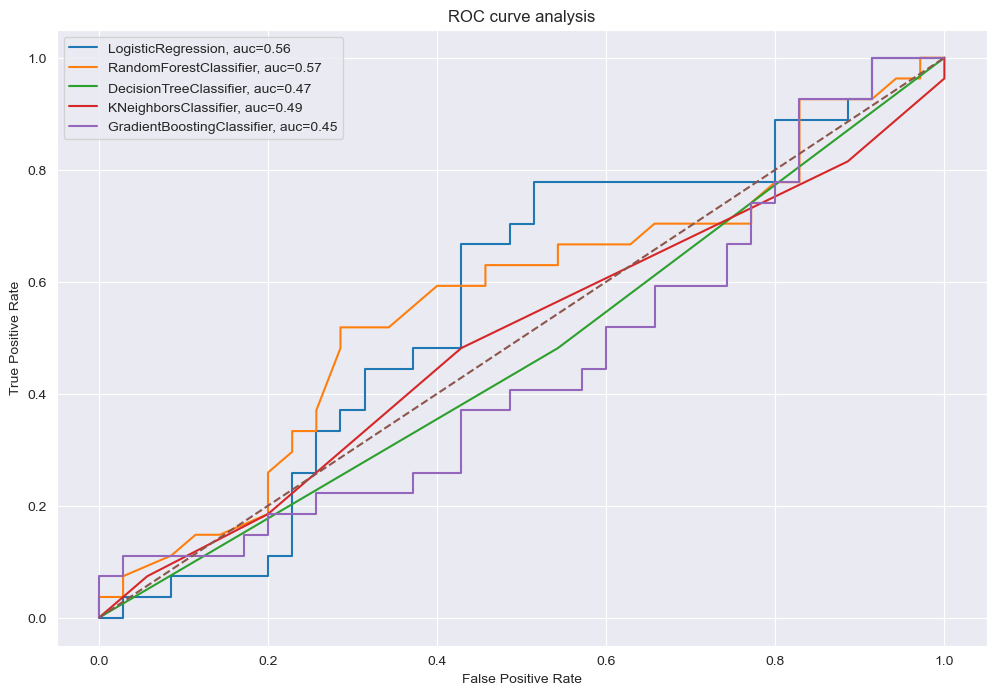

In [31]:
# List of Classifiers to plot ROC
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(),]

# Put the results in a DataFrame
result_df = pd.DataFrame(columns=['classifier', 'fpr', 'tpr', 'auc'])

# Train models and save the result
for classifier in classifiers:
    model = classifier.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[::,1]
    tpr, fpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    auc = roc_auc_score(y_test, y_prob)
    
    result_df = pd.concat([result_df, pd.DataFrame.from_dict({'classifier':[classifier.__class__.__name__],
                                 'fpr':[fpr],
                                 'tpr':[tpr],
                                 'auc':[auc]})])
    
# Make index the name of the classifier
result_df.set_index('classifier', inplace=True)

fig = plt.figure(figsize=(12,8))

for i in result_df.index:
    plt.plot(result_df.loc[i]['fpr'],
            result_df.loc[i]['tpr'],
            label=f"{i}, auc={round(result_df.loc[i]['auc'],2)}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve analysis')
plt.legend()
plt.show()

**Interpretation:** Random Forest and Logistic Regression were our best performers for modeling techniques. With a AUC score of 0.56 and 0.55 there could be some overfitting present in the baseline model. We will look at the test and validation predictions to see the performance.

---- Random Forest Results ----
Recall score for testing set:  0.5161
Recall score for validation set:  0.4286
Accuracy score for testing set:  0.4286
F1 score for testing set:  0.426




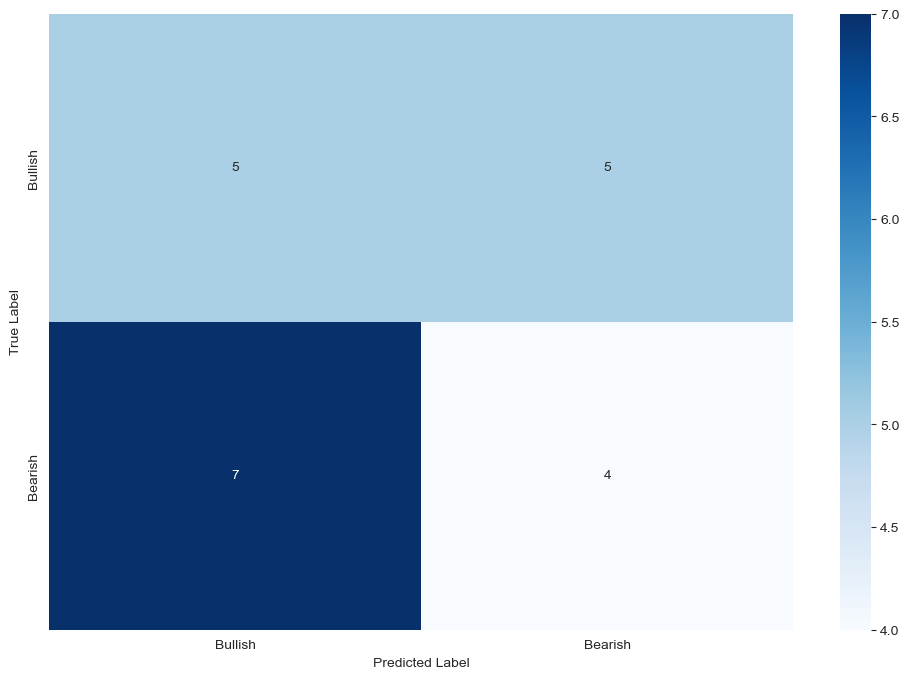

In [32]:
# Fit gradient boosting classifier and then print confusion matrix and scores.
rf.fit(X_train_scaled, y_train)
y_pred_test = rf.predict(X_test_scaled)
y_pred_val = rf.predict(X_val_scaled)
print('---- Random Forest Results ----')
print_results(y_test, y_pred_test, y_val, y_pred_val)
print('\n')
conf_matrix(y_val, y_pred_val)

**Interpretation:** Our F1 score is 0.4286 or 42.86% which is less than our target of 50.3% for model performance if we were to just guess the stock to drop the entire time. The sentiment from wallstreetbets seem to be a poor indicator for a prediction.

### Technicals Data
Create Functions for collecting and processing Technicals Data from AlphaVantage. These include indicators such as Relative Strength Index (RSI), Commodity Channel Index (CCI), and Average Directional Index (ADX). RSI provides a time based component to a trend to understand entries and exits while CCI and ADX measure the strength of a trend. We will see how this technical data will perform for classification modeling.

In [33]:
def get_rsi_data(api_key, stock):
    url = f"https://www.alphavantage.co/query?function=RSI&symbol={stock}&interval=daily&time_period=10&series_type=open&apikey={api_key}"
    raw = requests.get(url).json()

    return raw

def get_cci_data(api_key, stock):
    url = f"https://www.alphavantage.co/query?function=CCI&symbol={stock}&interval=daily&time_period=10&apikey={api_key}"
    raw = requests.get(url).json()

    return raw

def get_adx_data(api_key, stock):
    url = f"https://www.alphavantage.co/query?function=ADX&symbol={stock}&interval=daily&time_period=10&apikey={api_key}"
    raw = requests.get(url).json()

    return raw

def create_rsi_df(raw):
    dataframe = pd.DataFrame(columns=['Date', 'RSI'])

    for key in raw["Technical Analysis: RSI"].keys():
        dataframe = pd.concat([dataframe,
            pd.Series(
                [
                    datetime.strptime(key, '%Y-%m-%d').date(),
                    pd.to_numeric(raw["Technical Analysis: RSI"][key]['RSI']),         
                ], index=dataframe.columns
            ).to_frame().T
            ], ignore_index=True
        )
    return dataframe

def create_cci_df(raw):
    dataframe = pd.DataFrame(columns=['Date', 'CCI'])

    for key in raw["Technical Analysis: CCI"].keys():
        dataframe = pd.concat([dataframe,
            pd.Series(
                [
                    datetime.strptime(key, '%Y-%m-%d').date(),
                    pd.to_numeric(raw["Technical Analysis: CCI"][key]['CCI']),         
                ], index=dataframe.columns
            ).to_frame().T
            ], ignore_index=True
        )
    return dataframe

def create_adx_df(raw):
    dataframe = pd.DataFrame(columns=['Date', 'ADX'])

    for key in raw["Technical Analysis: ADX"].keys():
        dataframe = pd.concat([dataframe,
            pd.Series(
                [
                    datetime.strptime(key, '%Y-%m-%d').date(),
                    pd.to_numeric(raw["Technical Analysis: ADX"][key]['ADX']),         
                ], index=dataframe.columns
            ).to_frame().T
            ], ignore_index=True
        )
    return dataframe

def concat_dataframes(dataframe1, dataframe2):
    technicals_data = pd.concat([dataframe1, dataframe2], ignore_index=True)

In [34]:
# Create Price DataFrame
technicals_data = pd.DataFrame()
bad_api_calls = []
api_key = os.environ.get("API_KEY")

for stock in listing:
    try:
        # Make api call
        rsi_call = get_rsi_data(api_key, stock)
        cci_call = get_cci_data(api_key, stock)
        adx_call = get_adx_data(api_key, stock)
        
        # Create dataframe
        rsi_df = create_rsi_df(rsi_call)
        cci_df = create_cci_df(cci_call)
        adx_df = create_adx_df(adx_call)
        
        # Add column for stock symbol
        add_column(rsi_df, stock, 'stock')
        add_column(cci_df, stock, 'stock')
        add_column(adx_df, stock, 'stock')

        # Combine RSI, CCI, and ADX then add stock data to technicals_data
        df_temp = rsi_df.merge(cci_df, on=['Date', 'stock'], how='left', suffixes=(None, "_y"))
        df_temp = df_temp.merge(adx_df, on=['Date', 'stock'], how='left', suffixes=(None, "_y"))  
        technicals_data = pd.concat([technicals_data, df_temp], ignore_index=True)

    except KeyError:
        bad_api_calls.append(stock)
        pass

print(bad_api_calls)

[]


### Second Model - Technicals and Price Only
1. Merge and Preprocess Technicals and Price dataset to test performance of RSI, CCI, and ADX indicators.
2. Test model on different classifiers and compare to find the best option
3. Compare the performance with our baseline.

In [35]:
# Merge price and technicals dataset
tech_only = final_price_data.merge(technicals_data, on=['Date', 'stock'], how='left', suffixes=(None, "_y"))
# Drop columns that can lead to data leakage
tech_only.drop(['Date', 'Open', 'Close', '1d-logreturn', '10d-logreturn'], axis=1, inplace=True)
# Remove instances of no stock price movement
tech_only.drop(tech_only[tech_only['1d-direction'] == 0].index, inplace=True)
tech_only.dropna(inplace=True)
tech_only.reset_index(drop=True, inplace=True)

# Change columns to float
for column in tech_only.select_dtypes(exclude=[np.number]).columns:
    if column == 'stock':
        pass
    else:
        tech_only[column] = tech_only[column].astype(float)
        
tech_only.rename({'1d-direction': 'direction'}, axis=1,inplace=True)
tech_only.columns = tech_only.columns.map(lambda row: "_".join(row.lower().split(" ")))

In [36]:
# Set our X and y Variables
X = tech_only.drop(['direction'], axis=1)
y = tech_only['direction']

# One hot encode our stock column
one_hot = pd.get_dummies(X['stock'], drop_first=True)
X.drop(['stock'], axis=1, inplace=True)
X = pd.concat([X, one_hot], axis=1)
#X.drop(['AMD'], axis=1, inplace=True)

# Train test split and hold out a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42) #hold out 25% of the data for testing
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.25, random_state=42) #hold out 25% of the data for validation

# Scale our data with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [37]:
# Instantaite and test different classification models and compare scores
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)

lr = LogisticRegression(max_iter=1000)
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv = 5)

dt = DecisionTreeClassifier()
dt_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)

rf = RandomForestClassifier()
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)

gb = GradientBoostingClassifier(loss='exponential')
gb_scores = cross_val_score(gb, X_train_scaled, y_train, cv=5)

print(f"KNN mean scores: {np.mean(knn_scores):.4}")

print(f"Logistic Regression mean scores: {np.mean(lr_scores):.4}")

print(f"Decision Tree mean scores: {np.mean(dt_scores):.4}")

print(f"Random Forest mean scores: {np.mean(rf_scores):.4}")

print(f"Gradient Boosting mean scores: {np.mean(gb_scores):.4}")

# save best model
best_model = {
    knn: np.mean(knn_scores),
    lr: np.mean(lr_scores),
    rf: np.mean(rf_scores),
    gb: np.mean(gb_scores)
}

# sort by mean scores (dict values)
# then select the last model (highest mean scores)
best_model_dict = {k: v for k, v in sorted(best_model.items(), key=lambda item: item[1])}
best_model = list(best_model_dict.keys())[-1]

KNN mean scores: 0.4469
Logistic Regression mean scores: 0.5001
Decision Tree mean scores: 0.5001
Random Forest mean scores: 0.4999
Gradient Boosting mean scores: 0.5719


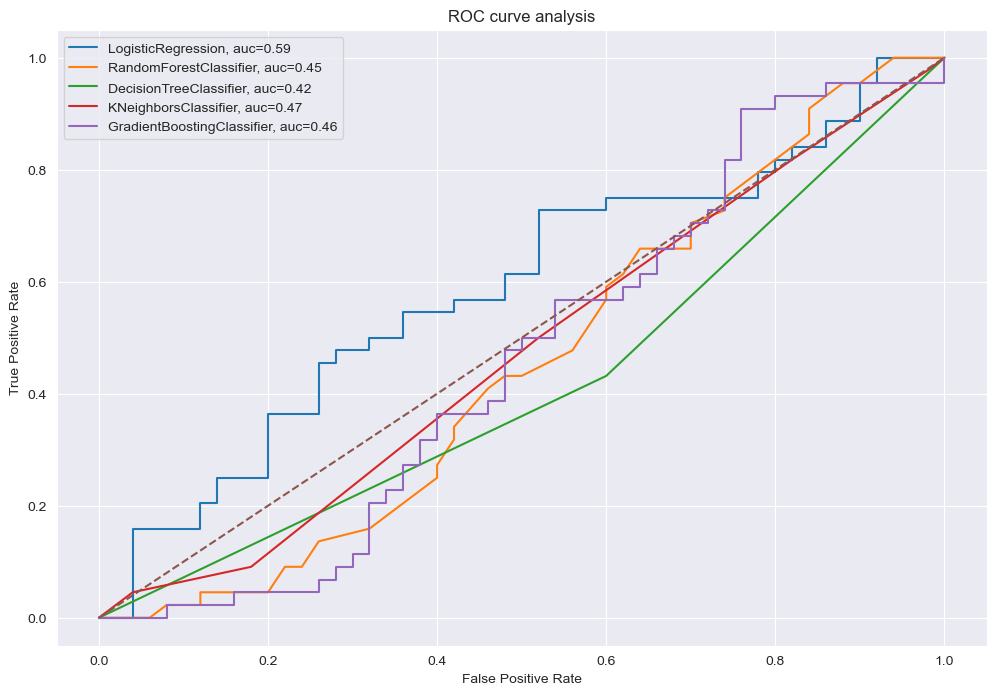

In [38]:
# List of Classifiers to plot ROC
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(),]

# Put the results in a DataFrame
result_df = pd.DataFrame(columns=['classifier', 'fpr', 'tpr', 'auc'])

# Train models and save the result
for classifier in classifiers:
    model = classifier.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[::,1]
    tpr, fpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    auc = roc_auc_score(y_test, y_prob)
    
    result_df = pd.concat([result_df, pd.DataFrame.from_dict({'classifier':[classifier.__class__.__name__],
                                 'fpr':[fpr],
                                 'tpr':[tpr],
                                 'auc':[auc]})])
    
# Make index the name of the classifier
result_df.set_index('classifier', inplace=True)

fig = plt.figure(figsize=(12,8))

for i in result_df.index:
    plt.plot(result_df.loc[i]['fpr'],
            result_df.loc[i]['tpr'],
            label=f"{i}, auc={round(result_df.loc[i]['auc'],2)}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve analysis')
plt.legend()

**Interpretation:** Logistic Regression was our best performing classifier for ROC but Gradient Boosting was the best for model accuracy. LogisticRegression is inherently better at estimating risk and so when looking at data derivied from only price movement but Gradient Boosting is extremely good at accuracy but prone to overfitting.

---- Gradient Boosting Results ----
Recall score for testing set:  0.4681
Recall score for validation set:  0.4062
Accuracy score for testing set:  0.4062
F1 score for testing set:  0.408




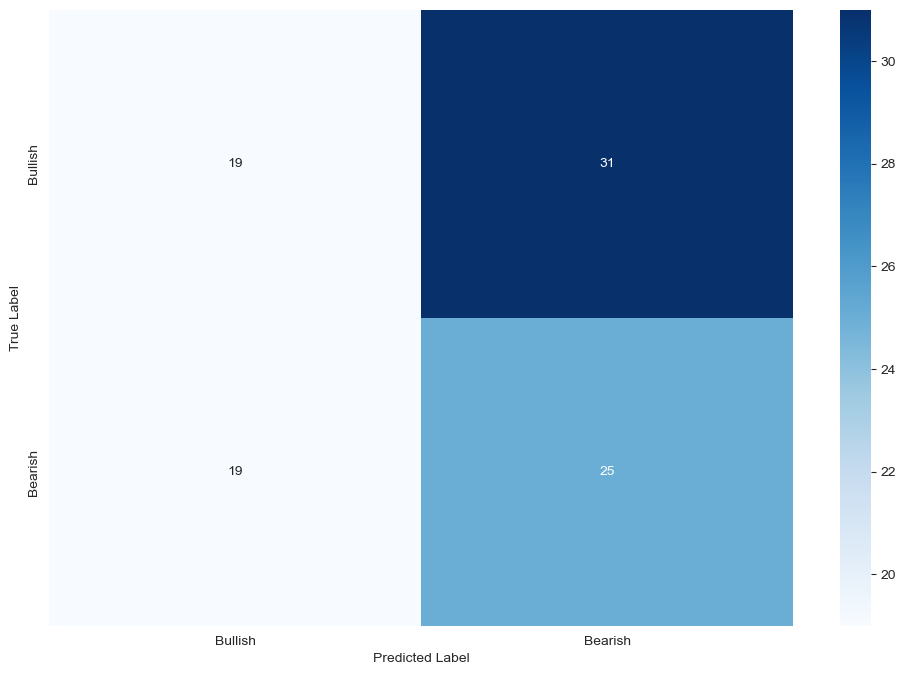

In [39]:
gb.fit(X_train_scaled, y_train)
y_pred_test = gb.predict(X_test_scaled)
y_pred_val = gb.predict(X_val_scaled)
print('---- Gradient Boosting Results ----')
print_results(y_test, y_pred_test, y_val, y_pred_val)
print('\n')
conf_matrix(y_test, y_pred_test)

---- Gradient Boosting Results ----
Recall score for testing set:  0.4574
Recall score for validation set:  0.4062
Accuracy score for testing set:  0.4062
F1 score for testing set:  0.408




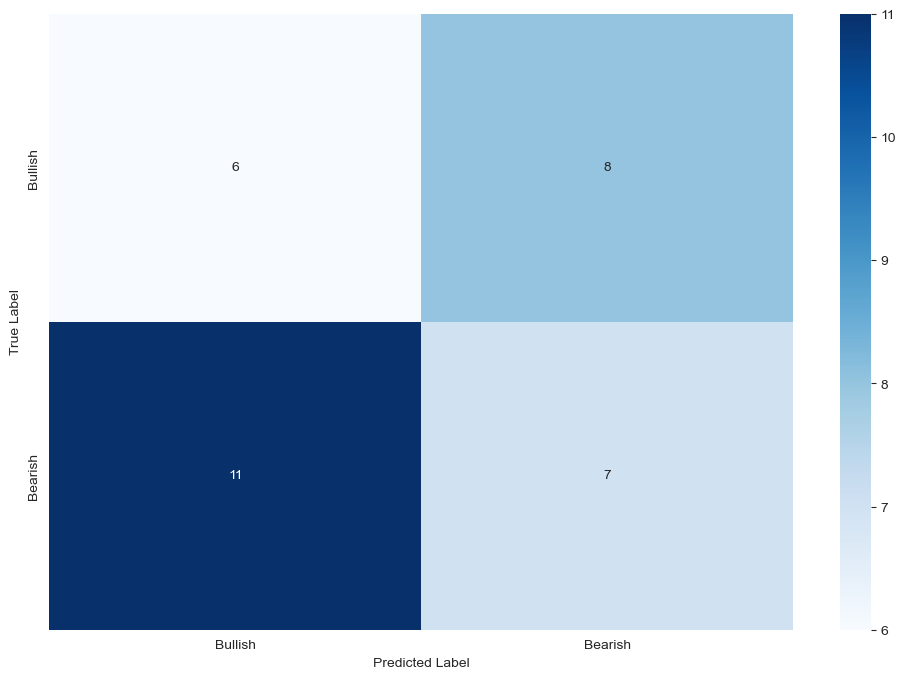

In [40]:
gb.fit(X_train_scaled, y_train)
y_pred_test = gb.predict(X_test_scaled)
y_pred_val = gb.predict(X_val_scaled)
print('---- Gradient Boosting Results ----')
print_results(y_test, y_pred_test, y_val, y_pred_val)
print('\n')
conf_matrix(y_val, y_pred_val)

**Interpretation:** The F1 score is 0.408 or 40.8% which is lower than our target 50.83% for performance measurement. It did not perform better than our sentiment data and would be not good at increasing our predictions alone. We do have to note that we only used 3 technical indicators as the API limited the number of calls we can make. It will be best to further research how the addition of many more technical indicators can better the performance of the technicals standalone model.

### All Data Modeling
1. Combine sentiment, price, and technicals dataset for preprocessing and modeling
2. Test model on different classifiers and compare to find the best option
3. Hyperparameter tune our best model to improve performance on unseen data.
4. Compare prediction accuracy and performance with baseline model.

In [41]:
sentiment_data = combined_data.drop(['text'], axis=1)
all_df = sentiment_data.merge(final_price_data, on=['Date', 'stock'], how='left', suffixes=(None, "_y"))
all_df = all_df.merge(technicals_data, on=['Date', 'stock'], how='left', suffixes=(None, "_y"))
all_df = all_df.groupby(by=['Date', 'stock']).mean()
all_df.reset_index(inplace=True)
all_df.drop(['Date', 'Open', 'Close', '1d-logreturn', '10d-logreturn', '30d-logreturn', '90d-logreturn'], axis=1, inplace=True)
all_df.drop(all_df[all_df['1d-direction'] == 0].index, inplace=True)
all_df.dropna(inplace=True)
all_df.reset_index(drop=True, inplace=True)

for column in all_df.select_dtypes(exclude=[np.number]).columns:
    if column == 'stock':
        pass
    else:
        all_df[column] = all_df[column].astype(float)
        
all_df.rename({'1d-direction': 'direction'}, axis=1,inplace=True)
all_df.columns = all_df.columns.map(lambda row: "_".join(row.lower().split(" ")))

In [42]:
X = all_df.drop(['direction'], axis=1)
y = all_df['direction']

one_hot = pd.get_dummies(X['stock'], drop_first=True)
X.drop(['stock'], axis=1, inplace=True)
X = pd.concat([X, one_hot], axis=1)
#X.drop(['AMD'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42) #hold out 25% of the data for testing
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.25, random_state=42) #hold out 25% of the data for validation

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [43]:
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)

lr = LogisticRegression(max_iter=1000)
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv = 5)

dt = DecisionTreeClassifier()
dt_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)

rf = RandomForestClassifier()
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)

gb = GradientBoostingClassifier(loss='exponential')
gb_scores = cross_val_score(gb, X_train_scaled, y_train, cv=5)

print(f"KNN mean scores: {np.mean(knn_scores):.4}")

print(f"Logistic Regression mean scores: {np.mean(lr_scores):.4}")

print(f"Decision Tree mean scores: {np.mean(dt_scores):.4}")

print(f"Random Forest mean scores: {np.mean(rf_scores):.4}")

print(f"Gradient Boosting mean scores: {np.mean(gb_scores):.4}")

# save best model
best_model = {
    knn: np.mean(knn_scores),
    lr: np.mean(lr_scores),
    rf: np.mean(rf_scores),
    gb: np.mean(gb_scores)
}

# sort by mean scores (dict values)
# then select the last model (highest mean scores)
best_model_dict = {k: v for k, v in sorted(best_model.items(), key=lambda item: item[1])}
best_model = list(best_model_dict.keys())[-1]

KNN mean scores: 0.5482
Logistic Regression mean scores: 0.5158
Decision Tree mean scores: 0.5158
Random Forest mean scores: 0.4917
Gradient Boosting mean scores: 0.4754


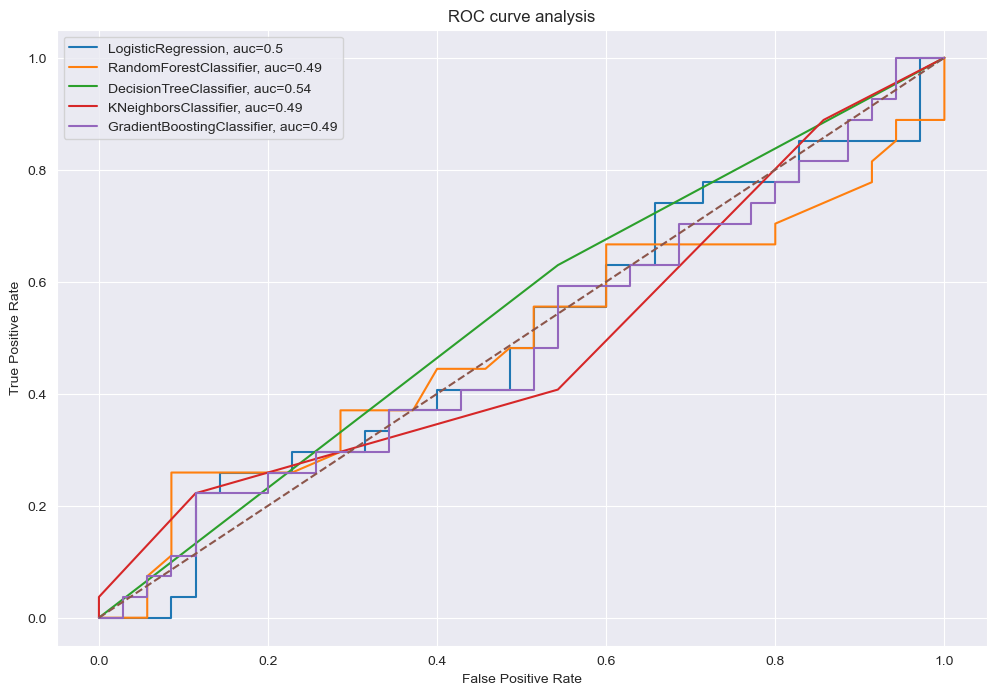

In [44]:
# List of Classifiers to plot ROC
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(),]

# Put the results in a DataFrame
result_df = pd.DataFrame(columns=['classifier', 'fpr', 'tpr', 'auc'])

# Train models and save the result
for classifier in classifiers:
    model = classifier.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[::,1]
    tpr, fpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    auc = roc_auc_score(y_test, y_prob)
    
    result_df = pd.concat([result_df, pd.DataFrame.from_dict({'classifier':[classifier.__class__.__name__],
                                 'fpr':[fpr],
                                 'tpr':[tpr],
                                 'auc':[auc]})])
    
# Make index the name of the classifier
result_df.set_index('classifier', inplace=True)

fig = plt.figure(figsize=(12,8))

for i in result_df.index:
    plt.plot(result_df.loc[i]['fpr'],
            result_df.loc[i]['tpr'],
            label=f"{i}, auc={round(result_df.loc[i]['auc'],2)}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve analysis')
plt.legend()
plt.show()

**Interpretation:** Gradient Boosting and Random Forest is our best classifiers when utilizing sentiment data. With auc score of 0.99 we can again see overfitting in our training set predictions. Let's see how the model will perform to unseen data and compare with our baseline.

---- Gradient Boosting Results ----
Recall score for testing set:  0.4839
Recall score for validation set:  0.4286
Accuracy score for testing set:  0.4286
F1 score for testing set:  0.4206




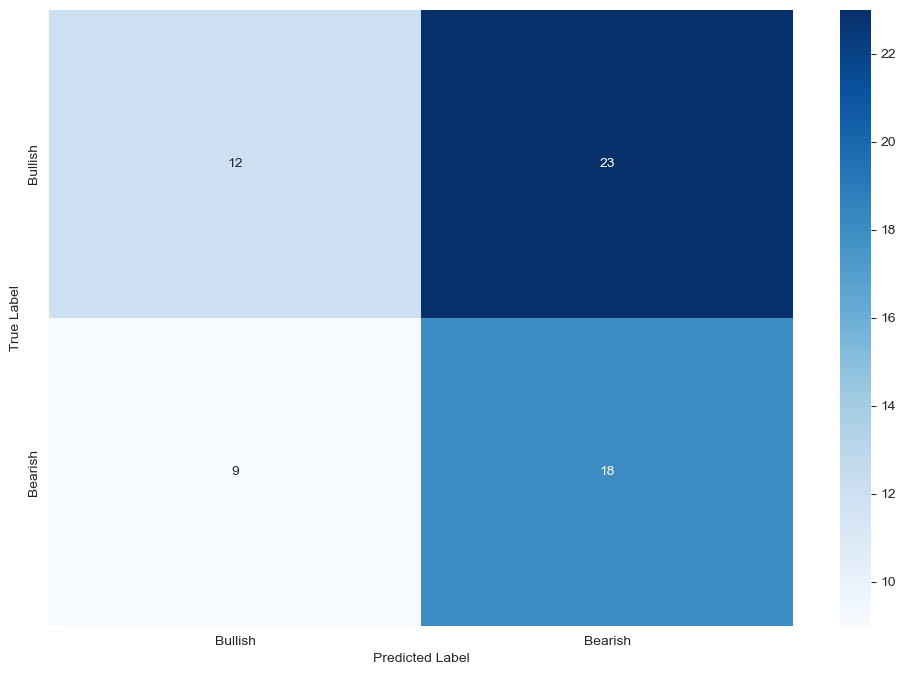

In [45]:
gb.fit(X_train_scaled, y_train)
y_pred_test = gb.predict(X_test_scaled)
y_pred_val = gb.predict(X_val_scaled)
print('---- Gradient Boosting Results ----')
print_results(y_test, y_pred_test, y_val, y_pred_val)
print('\n')
conf_matrix(y_test, y_pred_test)

---- Gradient Boosting Results ----
Recall score for testing set:  0.4677
Recall score for validation set:  0.4286
Accuracy score for testing set:  0.4286
F1 score for testing set:  0.4206




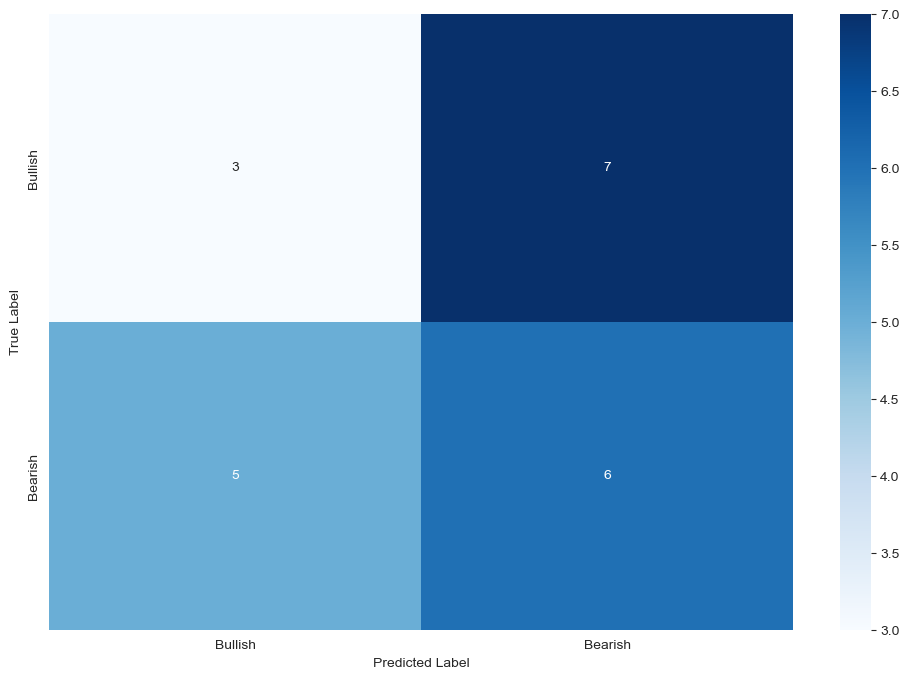

In [46]:
gb.fit(X_train_scaled, y_train)
y_pred_test = gb.predict(X_test_scaled)
y_pred_val = gb.predict(X_val_scaled)
print('---- Gradient Boosting Results ----')
print_results(y_test, y_pred_test, y_val, y_pred_val)
print('\n')
conf_matrix(y_val, y_pred_val)

**Interpretation:** The model has a F1 Score of 0.426 or 42.6% which is not higher than the 50.3% target and less than 42.8% for our baseline model. We will hyperparameter tune our model to improve performance as the addition of technicals will help our model make predictions on unseen data. We had a total of 15 False Positives and False Negatives out of 94 predictions.

### Hyperparameter Tuning the Gradient Boosting Model
1. iterate through different parameters and score with ROC and AUC to find best performing parameters
2. set the best parameters to instantaite our final model
3. Check model predictions performance on unseen data to compare with baseline.

In [47]:
gb = GradientBoostingClassifier(learning_rate=0.1)
param_grid = { 'min_samples_leaf':range(1,50, 10),
               'n_estimators':range(50, 201, 20),
               'max_depth':range(1,8,2),
               'max_features':[None, 'log2', 'sqrt']}
gsearch = GridSearchCV(estimator = gb, param_grid = param_grid, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch.fit(X_train_scaled, y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 1,
  'max_features': 'log2',
  'min_samples_leaf': 41,
  'n_estimators': 50},
 0.5645175275610058)

---- Tuned Gradient Boosting Results ----
Recall score for testing set:  0.5645
Recall score for validation set:  0.3333
Accuracy score for testing set:  0.3333
F1 score for testing set:  0.3013




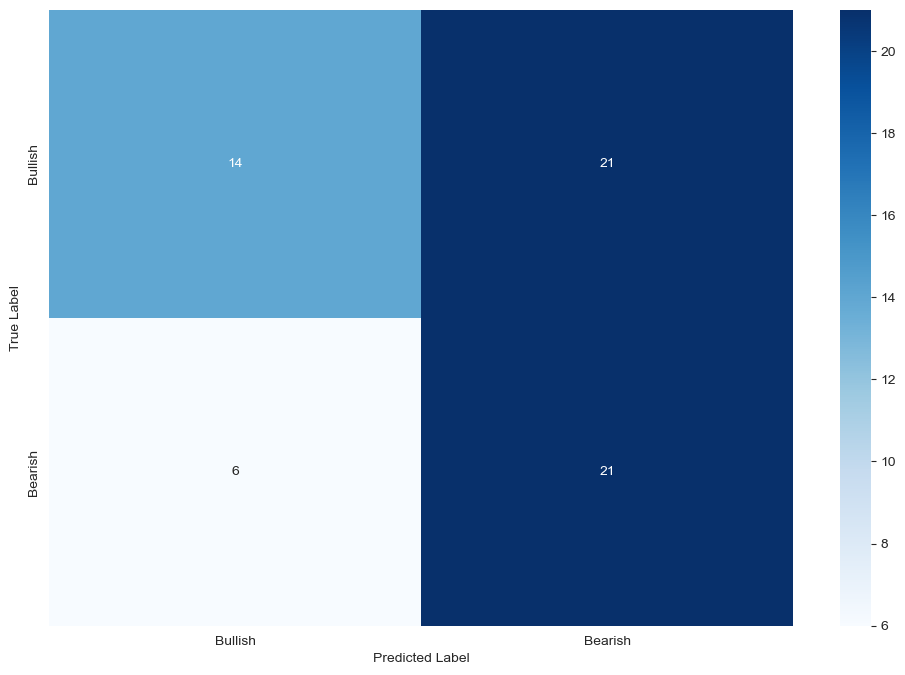

In [48]:
gb_tuned = GradientBoostingClassifier(learning_rate=0.1,
                                      max_depth=1,
                                      max_features='sqrt',
                                      min_samples_leaf=21,
                                      n_estimators=70)
gb_tuned.fit(X_train_scaled, y_train)
y_pred_test = gb_tuned.predict(X_test_scaled)
y_pred_val = gb_tuned.predict(X_val_scaled)
print('---- Tuned Gradient Boosting Results ----')
print_results(y_test, y_pred_test, y_val, y_pred_val)
print('\n')
conf_matrix(y_test, y_pred_test)

---- Tuned Gradient Boosting Results ----
Recall score for testing set:  0.5645
Recall score for validation set:  0.4286
Accuracy score for testing set:  0.4286
F1 score for testing set:  0.4206




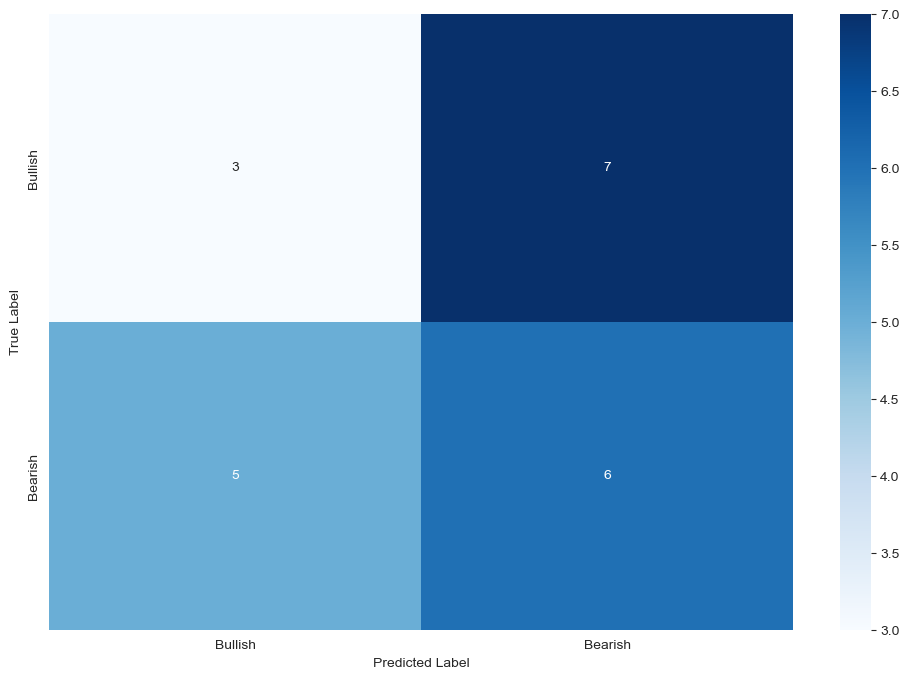

In [49]:
gb_tuned = GradientBoostingClassifier(learning_rate=0.1,
                                      max_depth=1,
                                      max_features='sqrt',
                                      min_samples_leaf=41,
                                      n_estimators=170)
gb_tuned.fit(X_train_scaled, y_train)
y_pred_test = gb_tuned.predict(X_test_scaled)
y_pred_val = gb_tuned.predict(X_val_scaled)
print('---- Tuned Gradient Boosting Results ----')
print_results(y_test, y_pred_test, y_val, y_pred_val)
print('\n')
conf_matrix(y_val, y_pred_val)

**Interpretation:** The F1 score is 0.4206 or 42.06%. We have solved alot of the overfitting problems with our Gradient boosting classifier on our final combined dataeset. The 42.06% performance does not exceed our 42.86% F1 score for the baseline model. The model through sentiment analysis and technical indicators can predict the direction of price movement for the next day 42.06% of the time.

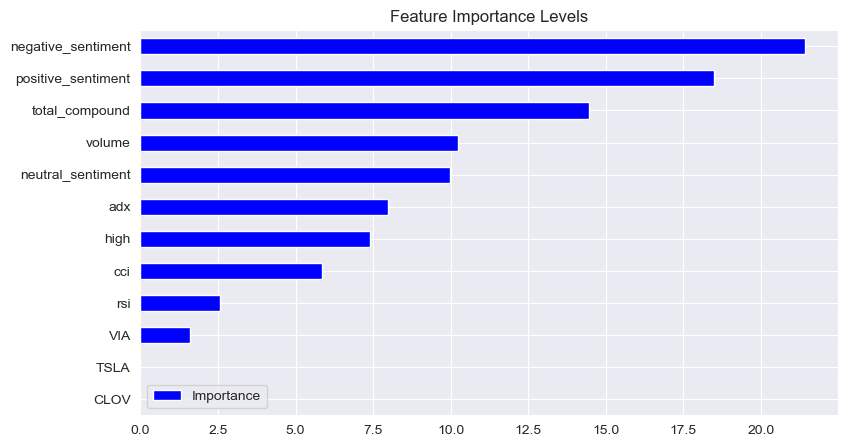

In [50]:
# Create DataFrame of our important features and sort by importance
Importances = pd.DataFrame({"Importance": gb_tuned.feature_importances_*100},index = X.columns)
Importances.sort_values(by = "Importance", axis = 0, ascending = True).tail(12).plot(kind ="barh", color = "b",figsize=(9, 5))
plt.title("Feature Importance Levels");
plt.show()

Importance is the amount that each feature split improves the performance and weighted by the number of observations in that node.

**Our final model shows that:**

1. Unlike previously thought ADX, CCI, and RSI helped in determining next day stock movement direction. These indicators do not perform well on their own and needed help from sentiment data.
2. TSLA being the most mentioned stock is not surprising to have alot of observations in that node.
3. Positive and negative sentiment had less observations in the node but helped the model split the data.

In [51]:
tsne_df = all_df.copy()
le = LabelEncoder()
le.fit(tsne_df['stock'])
tsne_df['stock'] = le.transform(tsne_df['stock'])

tsne = TSNE(random_state=1, n_iter=15000, metric='cosine', perplexity=40)

embs = tsne.fit_transform(tsne_df)
tsne_df['stock'] = le.inverse_transform(tsne_df['stock'])

# Add to dataframe for convenience
tsne_df['x'] = embs[:, 0]
tsne_df['y'] = embs[:, 1]

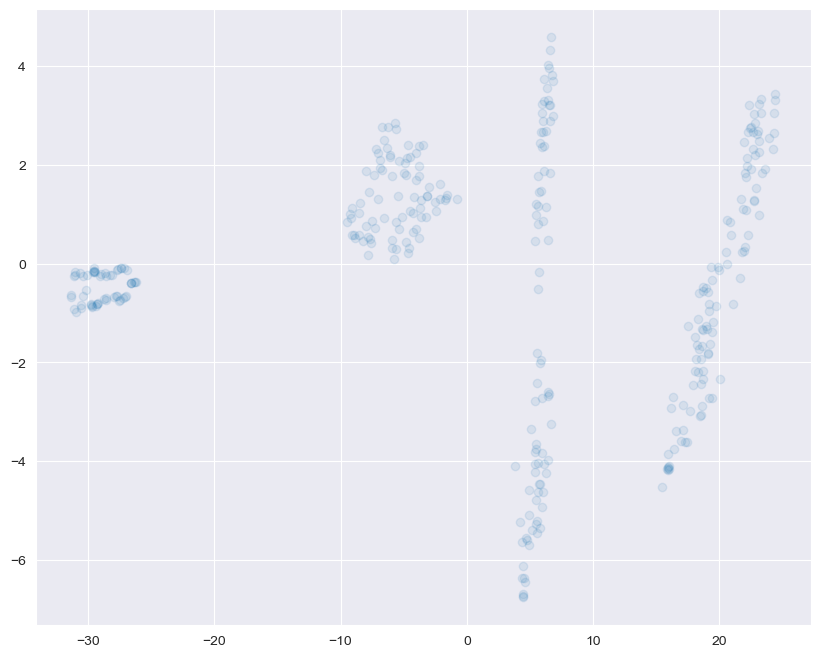

In [52]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(tsne_df.x, tsne_df.y, alpha=.1);

In [53]:
def plot_with_annotations(label_indices, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')

    return ax

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

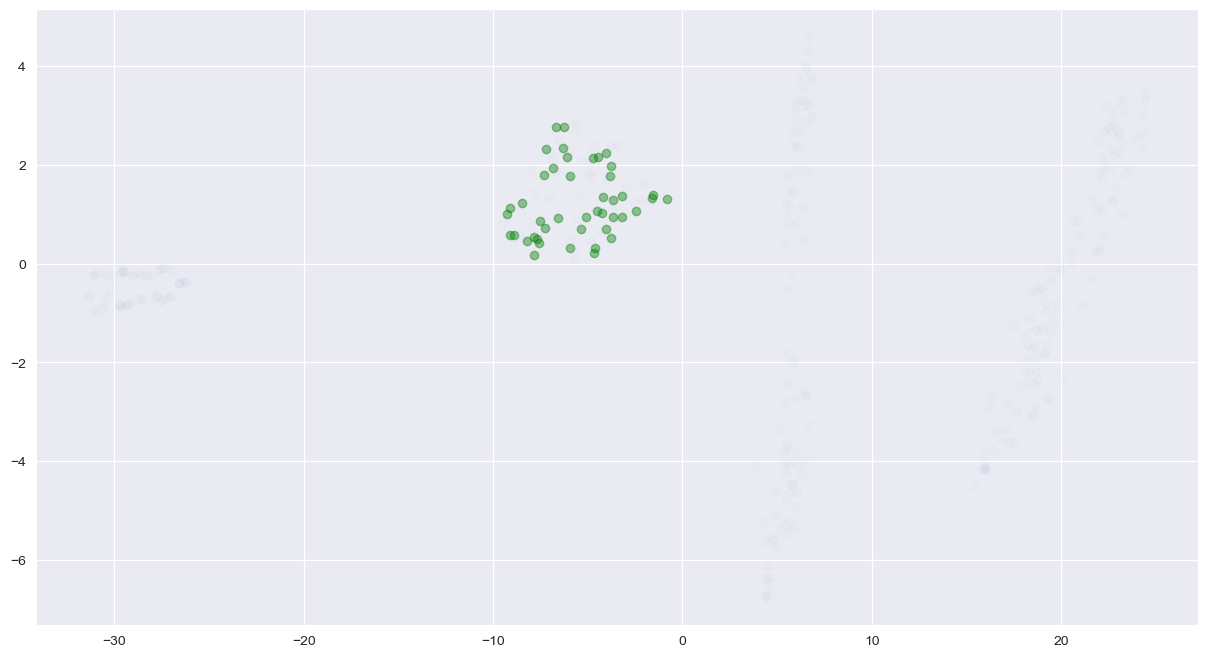

In [54]:
dirs = tsne_df[ (tsne_df['stock'] == 'TSLA') & (tsne_df['direction'] == 2) ]
plot_with_annotations(dirs.index, alpha=.4, figsize=(15, 8));

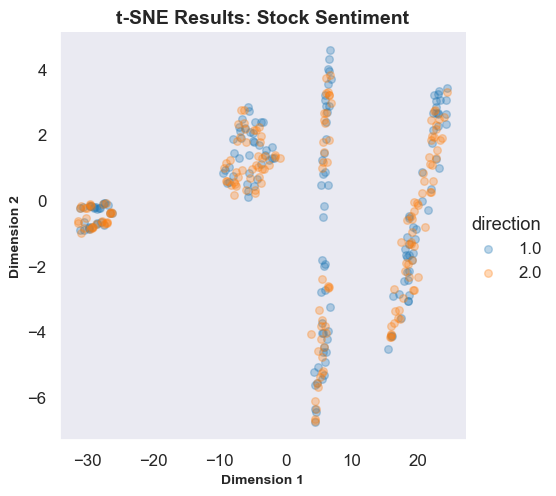

In [55]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("dark")
sns.lmplot(x='x',
           y='y',
           data=tsne_df,
           fit_reg=False,
           legend=True,
           hue='direction',
           scatter_kws={"s":30, "alpha":0.3})

plt.title('t-SNE Results: Stock Sentiment', weight='bold').set_fontsize('14')
plt.xlabel('Dimension 1', weight='bold').set_fontsize('10')
plt.ylabel('Dimension 2', weight='bold').set_fontsize('10')

## Conclusion
---
### Analysis
We learned alot about WallStreetBets and how Sentiment Scores can effect stock movement predictions:

1. We learned that Stock Movement predictions perform better when utilizing a combination of sentiment and technical indicators to make predictions.
2. Gradient Boosting Classifier was our best performing model and through hyperparameter tuning we found that the exponential loss function with max depth of 1 and 170 estimators provides the best model when measuring the ROC and AUC score.
3. Our features that held the most observations in its node and improved performance best in our classification model are our sentiment analysis. Where as RSI, CCI, and ADX did help they did not hold as much importance.
4. The technical indicators did not perform well on their own and overall worked best with the sentiment data derived from WallStreetBets posts. The final Model performed with a F1 Score of 42.06%
5. Overall we can conclude that WallStreetBets accuracy in their sentiment is poor and not a good indicator for prediction by itself. With additional sentiment from other forums it could perform much better. It does have an effect on the predictions and will be a good addition to our model and trading strategy.

### Recommendation
1. From our EDA we learned that retail investors have positive sentiment in posts around daily and weekly discussions and recommendations. We want to observe and monitor these posts to look for any indicators on market movement.
2. Within WSB posts we learned about the sentiment of popular online words such as Moon, Hold, and Rocket. My recommendation is to analyze posts for these sentiments to make informed decisions on what retail investors are doing.
3. Negative Sentiment is an important feature when it comes to modeling stock price movement. My recommendation is to utilize the model to understand fear and bearish sentiment on stocks for market opportunities to either buy at a discount or short trade.


### Next Steps
Our goal is to understand retail investors and how they communicate stock picks on online forums. With the power of numbers they have the ability to influence the market and at times of high volume in trading and lots of backing we can make predictions on the movement of these stocks. Our next steps are to:
1. We should look into other forums where retail investors communicate such as additional subreddits and or twitter. Collecting more data we can compare how different forums may have different sentiments on stocks and the performance of each forum on mentioned stocks.
2. Using our model we can better understand how retail investors can effect stocks that are very popular and their ability to influence the markets. We can make better purchase and selling decisions of these stocks in the short term by analyzing sentiment in popular forums.